In [1]:
#check what version of python you're using - I'm using 3.7.3
from platform import python_version
print(python_version())

# In[3]:

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

3.8.5


In [2]:
#image plotting in python
def implot(data, w, wcscond, vmax_p, vmin_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =vmin_p, vmax=vmax_p)
    plt.colorbar()
    plt.xlabel('RA')
    plt.ylabel('Dec')

    
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)



In [3]:
# path_data = 'inanna_runs/convs_and_regrids'
path_data = 'inanna_runs/cutout_fluxcutoff/'
files_data = [i.replace('\\', '/') for i in glob.glob(path_data+'*')]
hdu_list = [fits.open(i) for i in files_data[-3:]]

hdu_data_list = []
hdu_header_list = []

#I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
#the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
#I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
count = 0
for hdu_data in hdu_list:
    
    #reading in datafor general use  and header for wcs
    hdu_data_list.append(hdu_data[0].data)
    hdu_header_list.append(hdu_data[0].header)

    count += 1
    
w = WCS(hdu_header_list[0]) #I picked 0 arbitrarily, it shouldn't really matter
wcs_header = w.to_header()

In [ ]:
#example cell if you want to inspect and make cutouts of your images

#ordering arrays by wavelength...
#     implot(array2, w, False, np.mean(array2))
#     implot(hdu1_conv_scaled, w, False, np.mean(hdu1_conv_scaled)) 
#     implot(array, w, False, np.mean(array)) 
#     implot(array3, w, False, np.mean(array3)) 

#hh8ish
cen_x = 690 # 580
cen_y = 440 # 370
del_x = 150 # 1 #200 # 55
del_y = 150 # 1 #150 #100

#attempting hh7
cen_x = 570
cen_y = 155
del_x = 100
del_y = 65
# (570, 155), (65, 100)

# #HH9? The arcy feature thing
cutout1 = Cutout2D(hdu_data_list[0], (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut1 = cutout1.data
wcscut1 = cutout1.wcs 

cutout2 = Cutout2D(hdu_data_list[1], (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut2 = cutout2.data
wcscut2 = cutout2.wcs 

cutout3 = Cutout2D(hdu_data_list[2], (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut3 = cutout3.data
wcscut3 = cutout3.wcs 

cutout4 = Cutout2D(hdu_data_list[3], (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut4 = cutout4.data
wcscut4 = cutout4.wcs 

#plotting cutouts
implot(datacut1, wcscut1, False, np.mean(datacut1), 0) 
implot(datacut2, wcscut2, False, np.mean(datacut2), 0) 
implot(datacut3, wcscut3, False, np.mean(datacut3), 0) 
implot(datacut4, wcscut4, False, np.mean(datacut4), 0) 

sys.exit('Checking plots - exit')

[4.86241028e-18 3.05031887e-18 9.08031867e-18]
blackbody fit:  [1.21482341e+03 1.23702523e-28]
1 sigma:  [1.79072861e+02 1.43450471e-28]
curve_fit attempt:  [1.27990539e+01 6.90829485e-17 6.36301159e-17]
fFe/fH:  0.9210683288057091
sum(squared diffs):  2.5222601824674465e-66


C:\Users\arubi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


SystemExit: 

C:\Users\arubi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


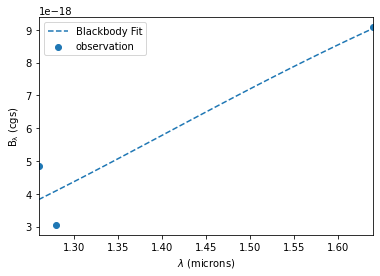

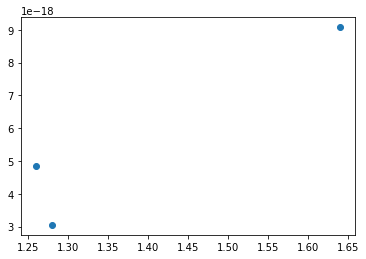

In [62]:
'''
This cell was my initial tests for a single pixel fitting

Using 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton_krylov.html#scipy.optimize.newton_krylovfor a non linear solver…

Try the algebraic solution… open up 4 images, 
put cursorover same place, see what values are…

Halpha of 12*.3 (can reduce to reduce negative amt)
1.2six of 1.3
Pabeta of 1.2  
1.six4 of 3

Q: How long it takes to 12k iterations?
That’s at me…See how long it takes on my computer 
vs. Inanna…fora bounded single pixel problem…

'''


#global vars for func
h = 6.626e-27 #CGS units, ergs*sec
c = 2.998e10 #CGS units, cm/s
k_B = 1.38e-16 #CGS, ergs/K

#list of wavelengths for each filter being used ... not sure how to code this automatically
# lam_arr = 1e-6 * np.array([0.656, 1.26, 1.28, 1.64]) #in SI
lam_arr = 1e-4 * np.array([0.656, 1.26, 1.28, 1.64]) #in CGS

#func for planck's law, cgs, output is as a flux
#https://yceo.yale.edu/sites/default/files/files/ComputingThePlanckFunction.pdf
def B_lam(input_arr, temp=4500, const =1e-25):
    lam = input_arr
    return const * 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)
    
    
#continuum of filament fluxes near hh 8
# cont_flux = np.array([np.mean(datacut1), np.mean(datacut2), np.mean(datacut3), np.mean(datacut4)] )
# print(cont_flux)
# cont_flux = np.array([np.max(datacut1), np.max(datacut2), np.max(datacut3), np.max(datacut4)] )
cont_flux = np.array([np.median(np.nan_to_num(i)) for i in hdu_data_list])
print(cont_flux)

#attempting many solvers
from scipy.optimize import newton_krylov
from scipy.optimize import minimize
from scipy.optimize import curve_fit
# xin = [500, 4.105e12] #K, const...initial guesses
# xin = [2.44402408e03, 2.56589326e-12]
xin = [2500, 5e-25]
popt, pcov = curve_fit(B_lam, lam_arr[1:], cont_flux, p0=xin) #solving!
print('blackbody fit: ', popt) #output
perr = np.sqrt(np.diag(pcov))
print('1 sigma: ', perr)


#plotting
plt.figure(212) #establish new figure
#plot to show results
plt.scatter(1e4*lam_arr[1:], cont_flux, label = 'observation') #the data

#plotting planck's law with fit params
lam_interp = np.linspace(lam_arr[1], lam_arr[-1])
plt.plot(1e4*lam_interp, B_lam(lam_interp, popt[0], popt[1]), linestyle='--', label = 'Blackbody Fit')

#formatting
plt.legend(loc='best')
# plt.ylim(min(cont_flux) - 9e-12, max(cont_flux) + 3e-11)
plt.xlim(1e4*lam_arr[1], 1e4*lam_arr[-1])
plt.xlabel(r'$\lambda$ (microns)')
plt.ylabel(r'$\rm {B}_{\lambda}$ (cgs)')





#global vars for func
R_Fe = 2.0#2.6
R_H = 17.5#24.5
y_arr = [0.47245, 0.77307, 0.78015, 0.85001]
T = popt[0] #2500.
C = popt[1] # 5e-29

#func for non-linear equation...
def scatt_func(lam_arr, A_V, f_H, f_Fe):
    return np.array([
#         (R_H * f_H + B_lam(lam_arr[0], T, C)) * y_arr[0]**A_V,
        (R_Fe * f_Fe + B_lam(lam_arr[0], T, C)) * y_arr[1]**A_V,
        (f_H + B_lam(lam_arr[1], T, C)) * y_arr[2]**A_V,
        (f_Fe + B_lam(lam_arr[2], T, C)) * y_arr[3]**A_V 
        ])

#attempting to fit using curve_fit
xin = [5, 1e-10, 1e-10]
popt, pcov = curve_fit(scatt_func, lam_arr[1:], cont_flux, p0=xin) #solving!
print('curve_fit attempt: ', popt)

A_V_fit, f_H_fit, f_Fe_fit = popt
# extinc_factor = y_arr**A_V
print('fFe/fH: ', f_Fe_fit / f_H_fit)

#chi^2 test...against curve_fit
obs_intens = cont_flux
theory_intens = scatt_func(lam_arr[1:], A_V_fit, f_H_fit, f_Fe_fit)
n_obs = len(obs_intens)
chi2 = np.sum((obs_intens - theory_intens)**2.)
print('sum(squared diffs): ', chi2)



#setting up a figure to plot on these fits...
plt.figure(213) #establish new figure
#plot to show results
plt.scatter(1e4*lam_arr[1:], cont_flux, label = 'Observed') #the data
# plt.scatter(1e6*lam_arr, scatt_func(lam_arr, C_fit, A_V_fit, f_H_fit, f_Fe_fit), label = 'Curve_Fit', s=20) #curve_fit method



sys.exit()





In [ ]:
#redefining function to setup a system of equations equal to 0 
def scatt_equ_solver(input_arr):
    C, A_V, f_H, f_Fe = input_arr
    equ_sys = cont_flux - np.array([
        (R_H * f_H + B_lam(lam_arr[0], T, C)) * y_arr[0]**A_V, 
        (R_Fe * f_Fe + B_lam(lam_arr[1], T, C)) * y_arr[1]**A_V,
        (f_H + B_lam(lam_arr[2], T, C)) * y_arr[2]**A_V,
        (f_Fe + B_lam(lam_arr[3], T, C)) * y_arr[3]**A_V 
        ])
#     print(equ_sys)
    return equ_sys

#trying to solve system with non-lin solver
from scipy.optimize import newton_krylov
from scipy.optimize import anderson
from scipy.optimize import broyden1
from scipy.optimize import broyden2
xin1 = [1.97416054e-23,  5.23938071,  8.62153822e-11,  6.25492719e-11] #initial guess
xin2 = [2e-23, 5.2, 9e-11, 6.3e-11] #initial guess
xin3 = [2e-22, 2, 5e-11, 5e-11] #initial guess
xin4 = [1e-10, 5, 1e-5, 1e-5] #initial guess
xin5 = [2e-23, 10, 1e-12, 1e-12] #initial guess
xin_list = [xin1, xin2, xin3, xin4, xin5]

'''
Notes from testing newton-krylov...of possible methods one can adjust
#default: max iter can be 30-100, step can be 1e-10 to 1e-14
#for all except cgs, can use iter of 10,000 or 100,000\
#for cgs can use 5000
#that said, cgs isn't great, gmres and bicgstab seem best
#min f_tol = 4.95e-12...maxiter with bicgstab can go up to say 100000...seems to level off at about 300 to 1000? checking...
'''
met = ['lgmres', 'gmres', 'bicgstab', 'cgs', 'minres']
k = met[2]

#loop testing different numbers of iterations
iter_list = [1, 5, 10, 100, 200]
# for i in [1, 5, 10, 100, 200]:
i = 100
# for j in range(len(xin_list)):
#     for k in met:
#         try:
#             print('loop: ', i, k)


solved = newton_krylov(scatt_equ_solver, [3.47240353e-30,  5.,  2.51609301e-17,  4.99527923e-17]) #, iter = i, method=k) #non-lin solver
# solved = newton_krylov(scatt_equ_solver, xin_list[0], iter = i, method=k) #non-lin solver
# solved = anderson(scatt_equ_solver, xin_list[0], f_tol=9e-12) #non-lin solver
# solved = broyden1(scatt_equ_solver, xin_list[-1], f_tol=1e-11) #non-lin solver
# solved = broyden2(scatt_equ_solver, xin_list[0], iter = i) #non-lin solver

print('non-linear attempt: ', solved)

#separating fit into diff variables...calculating a sum of squared diffs
C_nk, A_V_nk, f_H_nk, f_Fe_nk = solved
print('fit intensities: ', scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk))
#calculating sum of squared diffs...against newton-krylov
theory_intens = scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk)
chi2 = np.sum((obs_intens - theory_intens)**2.)
print('sum(squared diffs): ', chi2)

# extinc_factor = y_arr**A_V
print(f_Fe_nk / f_H_nk)
#"sanity check" for founds on Fe/H


#check how much time this took
# stop = timeit.default_timer()
# print('Time: ', stop - start)  


#plotting non-linear fit to intensity
# lam_interp = np.linspace(lam_arr[0], lam_arr[-1])
plt.scatter(1e4*lam_arrlam_arr[1:], scatt_func(lam_arrlam_arr[1:], C_nk, A_V_nk, f_H_nk, f_Fe_nk), label = 'N-K, iter='+str(i), s=20)
#             print('success')
#         except: 
#             print('error')

#         print('RESET')
#formatting our plot
plt.legend(loc='best')
plt.ylim(min(cont_flux) - 3e-12, max(cont_flux) + 3e-12)
plt.xlim(1e4*lam_arr[1], 1e4*lam_arr[-1])
plt.xlabel(r'$\lambda$ (microns)')
plt.ylabel(r'$\rm Intensity$ (W/m^3/sr)')